In [5]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import mnist
import keras

In [48]:
X_train = mnist.train_images()
y_train = mnist.train_labels()
X_test = mnist.test_images()
y_test = mnist.test_labels()

# normalize the images
X_train = (X_train/255)-0.5
X_test = (X_test/255)-0.5

# Expand dimensionality of images from 2 to 3 dims
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

Preview the first 20 images from the dataset

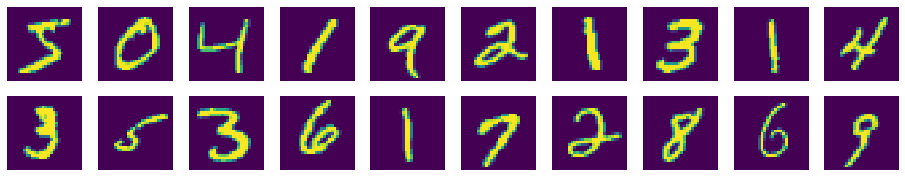

In [44]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(16, 3))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train[i])
    ax.axis('off')
plt.show()

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

num_filter = 8
filter_size = 3
pool_size = 2
model = Sequential([
    Conv2D(num_filter, filter_size, input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=pool_size),
    Flatten(),
    Dense(10, activation='softmax')
])

In [20]:
model.compile('Adam', 'categorical_crossentropy', metrics=['accuracy'])

In [50]:
from keras.utils import to_categorical
model.fit(X_train, to_categorical(y_train), epochs=3, validation_data=(X_test, to_categorical(y_test)))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 13s 210us/step - loss: 0.3345 - accuracy: 0.9053 - val_loss: 0.1864 - val_accuracy: 0.9465
Epoch 2/3
60000/60000 [==============================] - 12s 208us/step - loss: 0.1649 - accuracy: 0.9518 - val_loss: 0.1402 - val_accuracy: 0.9575
Epoch 3/3
60000/60000 [==============================] - 12s 206us/step - loss: 0.1235 - accuracy: 0.9647 - val_loss: 0.1143 - val_accuracy: 0.9652


We can now compare our model' predictions with the ground truth

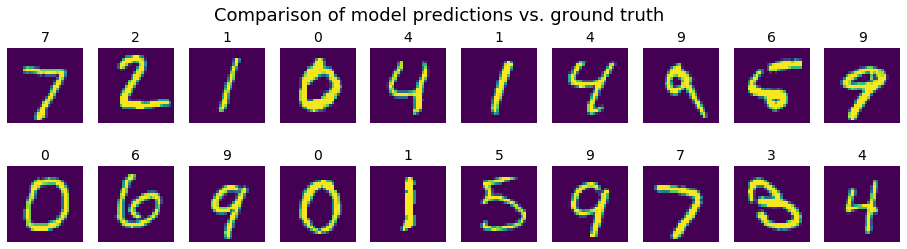

In [241]:
# predictions
y_pred = model.predict_classes(X_test[:20])

fig, axs = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(16, 4))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_test[i].reshape(28, 28))
    ax.axis('off')
    ax.set_title('{}'.format(y_pred[i]), fontsize=14)
fig.suptitle('Comparison of model predictions vs. ground truth', fontsize=18)
plt.show()

We have one obvious false prediction. The 5 in the second row at position 6 was predicted 6 by the model.

Now let's apply the integrated gradients to see what patterns in the data the model understands.

In [86]:
from keras import backend as K
def integrated_gradients(inp, baseline=None, steps=50):
    """My own implementation of the integrated gradients. I've made this over the formula under section "Computing
    Integrated Gradients". Returns the a vector of attributions where each element in the vector corresponds to one
    value in the input. The attributions vector has the same shape as the input.
    
    @Params
    ------
    inp:    The target input. i.e. One input sample (numpy.array) (e.g. one image, one molecule).
    
    baseline:      (Optional) The baseline vector - if not provided, the zero-vector is calcualted.
    
    steps:         (Optional), number of steps for integral estimation. = 50 by default

    @Returns
    -------
    Attribution vector
    """
    if baseline is None:
        baseline = np.zeros(inp.shape)
    # gamma calculates the path function for a given alpha
    gamma = lambda alpha: baseline + alpha*(inp - baseline)
    input_tensor = np.array([gamma(alpha) for alpha in np.linspace(0, 1, num=51)])
    output_tensor = model.predict(input_tensor)
    gradient = K.gradients(model.output, model.input)[0]
    sess = K.get_session()
    results = sess.run(gradient, feed_dict={model.output: output_tensor, model.input: input_tensor})
    return (inp-baseline) * np.average(results, axis=0)

In [176]:
baseline = np.matrix([[-.5]*28*28]).reshape(1, 28, 28)
baseline = np.expand_dims(baseline, 3)
attributions = np.array([integrated_gradients(inp, baseline=baseline, steps=100) for inp in X_test[:20]])

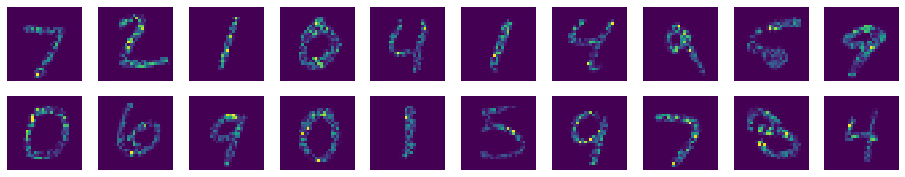

In [195]:
fig, axs = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(16, 3))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.abs(attributions[i].reshape(28, 28)))
    ax.axis('off')
plt.show()

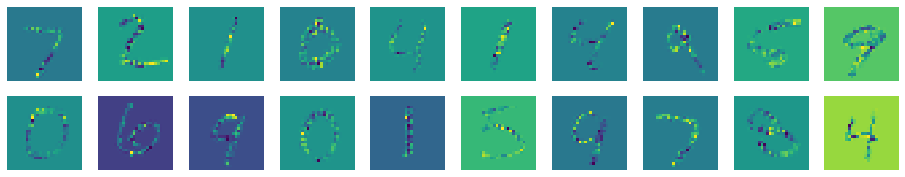

In [197]:
fig, axs = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(16, 3))
for i, ax in enumerate(axs.flatten()):
    vis_gradients = np.multiply(X_test[i].reshape(28, 28), attributions[i].reshape(28, 28))
    ax.imshow(vis_gradients)
    ax.axis('off')
plt.show()

In [156]:
color_intensity = np.linspace(0, 255, 28*28).reshape(28, 28)

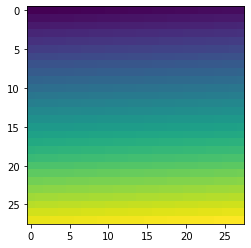

In [157]:
blank_matrix = np.matrix([0]*28*28).reshape(28, 28)
plt.imshow(color_intensity)

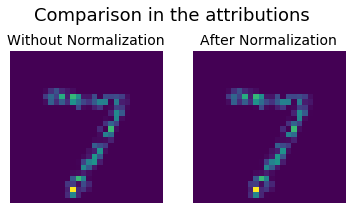

In [223]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 3.5))
# without normalization
axs[0].imshow(np.abs(attributions[0].reshape(28, 28)))
axs[0].axis('off')
axs[0].set_title('Without Normalization', fontsize=14)
# after normalization
axs[1].imshow((np.abs(attributions[0]/np.max(attributions[0])) - .5).reshape(28, 28))
axs[1].axis('off')
axs[1].set_title('After Normalization', fontsize=14)
fig.suptitle('Comparison in the attributions', fontsize=18)
plt.show()

I can't tell much difference between before and after normalizing the attributions.

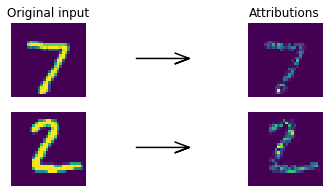

In [274]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(6, 3))
# true labels
axs[0][0].imshow(X_test[0].reshape(28, 28))
axs[0][0].axis('off')
axs[1][0].imshow(X_test[1].reshape(28, 28))
axs[1][0].axis('off')
axs[0][0].set_title('Original input')


# arrows
axs[0][1].plot([5, 20, 16, 20, 16], [13, 13, 15, 13, 11], c='black')
axs[0][1].axis('off')
axs[1][1].plot([5, 20, 16, 20, 16], [13, 13, 15, 13, 11], c='black')
axs[1][1].axis('off')

# attributions
axs[0][2].imshow(np.abs(attributions[0].reshape(28, 28)))
axs[0][2].axis('off')
axs[1][2].imshow(np.abs(attributions[1].reshape(28, 28)))
axs[1][2].axis('off')
axs[0][2].set_title('Attributions')
fig.savefig('plots/highlighted_attributions_CNNs', dpi=300, bbox_inches='tight')
plt.show()

I will demonstrate image perturbation in here

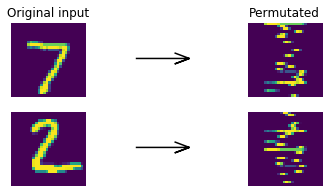

In [275]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(6, 3))
# true labels
axs[0][0].imshow(X_test[0].reshape(28, 28))
axs[0][0].axis('off')
axs[1][0].imshow(X_test[1].reshape(28, 28))
axs[1][0].axis('off')
axs[0][0].set_title('Original input')


# arrows
axs[0][1].plot([5, 20, 16, 20, 16], [13, 13, 15, 13, 11], c='black')
axs[0][1].axis('off')
axs[1][1].plot([5, 20, 16, 20, 16], [13, 13, 15, 13, 11], c='black')
axs[1][1].axis('off')

# attributions
axs[0][2].imshow(np.random.permutation(X_test[0].reshape(28, 28)))
axs[0][2].axis('off')
axs[1][2].imshow(np.random.permutation(X_test[0].reshape(28, 28)))
axs[1][2].axis('off')
axs[0][2].set_title('Permutated')
fig.savefig('plots/images_perturbation_CNNs', dpi=300, bbox_inches='tight')
plt.show()

In [285]:
import time

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [289]:
from modules.IntegratedGradients import integrated_gradients as IG
ig = IG(model)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [292]:
attributions_github = np.array([ig.explain(inp, reference=baseline, num_steps=100) for inp in X_test[:20]])

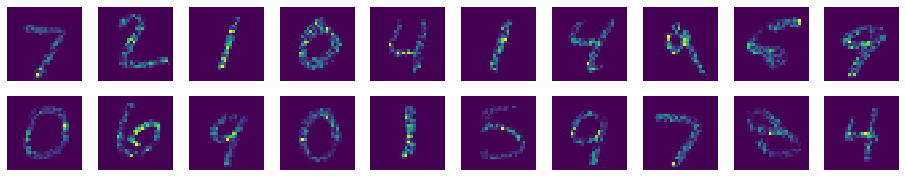

In [293]:
fig, axs = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(16, 3))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.abs(attributions_github[i].reshape(28, 28)))
    ax.axis('off')
plt.show()

In [296]:
attributions_github = np.array([ig.explain(inp, reference=baseline, num_steps=1000) for inp in X_test[:20]])

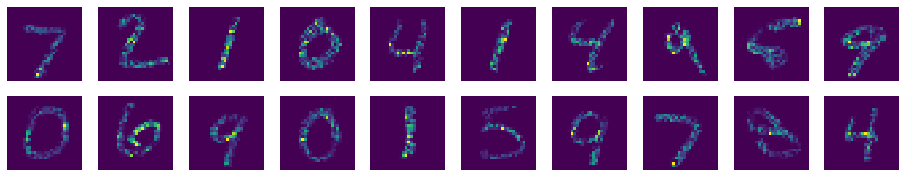

In [297]:
fig, axs = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(16, 3))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.abs(attributions_github[i].reshape(28, 28)))
    ax.axis('off')
plt.show()

Increasing the number of steps by 10 as much doesn't highlight more information

In [325]:
diffs = np.array(list(map(np.sum, attributions.reshape(20, 28, 28)))) - np.array(list(map(np.sum, attributions_github.reshape(20, 28, 28))))

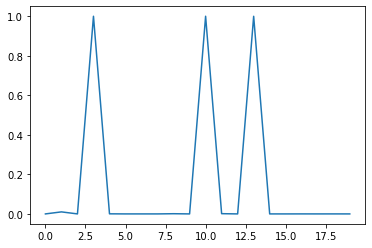

In [330]:
plt.plot(np.abs(diffs))

We can try out different baselines

Text(0.5, 1.0, 'Modal Baseline')

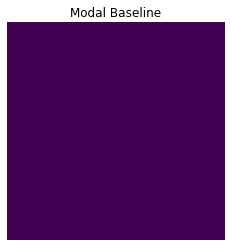

In [308]:
from scipy.stats import mode
baseline_modal = mode(X_test, axis=0)[0].reshape(28, 28, 1)
plt.imshow(baseline_modal.reshape(28, 28))
plt.axis('off')
plt.title('Modal Baseline')

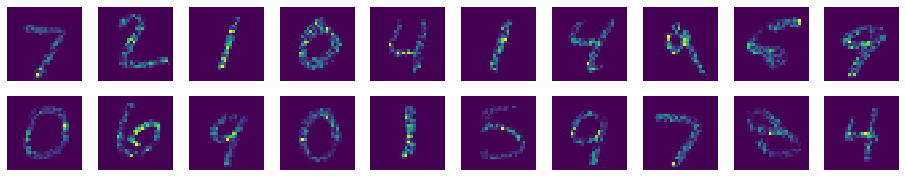

In [310]:
modal_attributions_github = np.array([ig.explain(inp, reference=baseline_modal, num_steps=100) for inp in X_test[:20]])
fig, axs = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(16, 3))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.abs(modal_attributions_github[i].reshape(28, 28)))
    ax.axis('off')
plt.show()